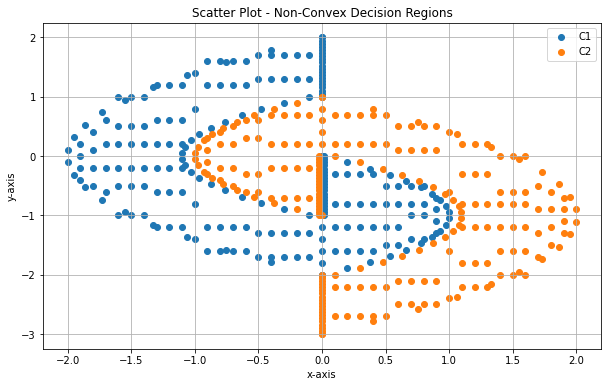

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

datapoints = pd.read_csv('Datapoints.csv')

y_1 = np.linspace(1,2,20)
x_1 = np.zeros(20) 

y_2 = np.linspace(-1,0,20)
x_2 = np.full((20),0.02)

y_3 = np.linspace(-2,0,20)
x_3 = -1*(y_3+1)**2 + 1

y_4 = np.linspace(-1,1,20)
x_4 = y_4**2 - 1.1

y_5 = np.linspace(-2,2,20)
x_5 = (1/2)*y_5**2 - 2

x_c1 = datapoints['x_c1']
y_c1 = datapoints['y_c1']

y_6 = np.linspace(-3,-2,20)
x_6 = np.zeros(20) 

y_7 = np.linspace(-1,0,20)
x_7 = np.full((20),-0.02)

y_8 = np.linspace(-1,1,20)
x_8 = y_8**2 - 1

y_9 = np.linspace(-2,0,20)
x_9 = -1*(y_9+1)**2 + 1.1

y_10 = np.linspace(-3,1,20)
x_10 = (-1/2)*(y_10+1)**2 + 2

x_c2 = datapoints['x_c2']
y_c2 = datapoints['y_c2']

C1_x = np.concatenate((x_1, x_2, x_3, x_4, x_5, x_c1 ))
C1_y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_c1 ))

C2_x = np.concatenate((x_6, x_7, x_8, x_9, x_10, x_c2))
C2_y = np.concatenate((y_6, y_7, y_8, y_9, y_10, y_c2))

C1 = np.array([list(pair) for pair in zip(C1_x, C1_y)])
C2 = np.array([list(pair) for pair in zip(C2_x, C2_y)])

fig = plt.figure(figsize = (10, 6))
plt.grid()
plt.scatter(C1[:,0], C1[:,1],)
plt.scatter(C2[:,0], C2[:,1])
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(["C1", "C2"], loc ="upper right")
plt.title('Scatter Plot - Non-Convex Decision Regions')
plt.show()

label_1 = ['C1']*len(C1)
label_2 = ['C2']*len(C2)
label = label_1 + label_2

coordinates = pd.DataFrame(np.concatenate((C1,C2)))
coordinates.columns = ['x', 'y']
coordinates['region'] = label
coordinates = shuffle(coordinates, random_state= 42)

label_region = LabelEncoder()
coordinates['region'] = label_region.fit_transform(coordinates['region'])
scaler = MinMaxScaler()
coordinates[['x','y']] = scaler.fit_transform(coordinates[['x','y']])
                                                                                           
X = np.array(coordinates.drop('region', axis = 1))
y = np.array(coordinates['region'])

X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [3]:
class CounterpropagationNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        self.hidden_weights = np.random.rand(hidden_size, input_size)#Kohnen Layer
        self.output_weights = np.random.rand(output_size, hidden_size)#Grossberg Outstar Layer

    def train(self, X_train, y_train, X_test, y_test, num_epochs, alpha, beta, decay_rate):
        history = {'epoch':[], 'training_accuracy': [], 'validation_accuracy':[] }
        for epoch in range(num_epochs):
            predictions = []
            for i in range(len(X_train)):
                
                # Forward pass
                hidden_activations = self._compute_hidden_activations(X_train[i])
                output_activations = self._compute_output_activations(hidden_activations)

                # Backward pass
                output_errors = y_train[i] - output_activations
                hidden_errors = self._compute_hidden_errors(hidden_activations, output_errors)

                # Update weights
                self._update_output_weights(hidden_activations, output_errors, beta)
                self._update_hidden_weights(X_train[i], hidden_errors, alpha)
                
                predictions = np.append(predictions,output_activations)

            # Learning rates diminishes after every epoch
            alpha*= decay_rate
            beta*= decay_rate
            train_accuracy = accuracy_score(y_train,np.where(predictions>0.5,1,0))
            val_accuracy = accuracy_score(y_test, np.where(self.predict(X_test)>0.5,1,0))
            history["epoch"].append(epoch)
            history["training_accuracy"].append(train_accuracy)
            history["validation_accuracy"].append(val_accuracy)
            
        return history

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            hidden_activations = self._compute_hidden_activations(X[i])
            output_activations = self._compute_output_activations(hidden_activations)
            predictions = np.append(predictions,output_activations)
        return predictions


    def _compute_hidden_activations(self, x):
        return np.dot(self.hidden_weights, x) 

    def _compute_output_activations(self, h):
        return np.dot(self.output_weights, h)

    def _compute_hidden_errors(self, h, output_errors):
        return np.multiply(np.dot(self.output_weights.T, output_errors), np.multiply(h, 1 - h))

    def _update_hidden_weights(self, x, hidden_errors, alpha):
        delta_w = alpha * np.outer(hidden_errors, x)
        self.hidden_weights += delta_w

    def _update_output_weights(self, hidden_activations, output_errors, beta):
        delta_w = beta * np.outer(output_errors, hidden_activations)
        self.output_weights += delta_w
              
if __name__ == '__main__':
    
    cpn = CounterpropagationNetwork(input_size=2, hidden_size = 150, output_size=1)
    start_time = time.time()
    history = pd.DataFrame(cpn.train(X_train, y_train, X_test, y_test, 30, 0.01,0.01, 0.9))
    end_time = time.time()
    print("Training time: %.2f " %(end_time - start_time))
    print(history)

Training time: 1.14 
    epoch  training_accuracy  validation_accuracy
0       0           0.637363             0.630435
1       1           0.626374             0.630435
2       2           0.634615             0.630435
3       3           0.626374             0.641304
4       4           0.640110             0.641304
5       5           0.631868             0.652174
6       6           0.653846             0.652174
7       7           0.651099             0.663043
8       8           0.656593             0.652174
9       9           0.648352             0.652174
10     10           0.651099             0.673913
11     11           0.651099             0.684783
12     12           0.656593             0.652174
13     13           0.653846             0.663043
14     14           0.648352             0.728261
15     15           0.651099             0.739130
16     16           0.648352             0.739130
17     17           0.651099             0.750000
18     18           0.648352 

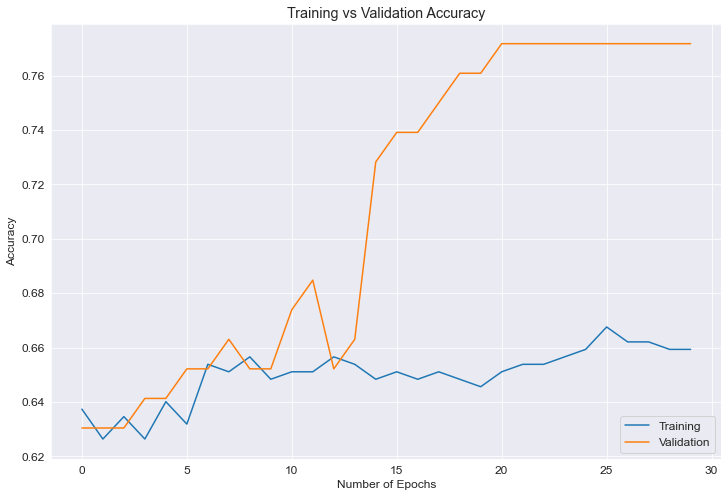

In [6]:
sns.set_style("darkgrid") #Enabling grid of the graphs
plt.figure(figsize=(12,8))
plt.plot(history['epoch'], history['training_accuracy'])
plt.plot(history['epoch'], history['validation_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(["Training", "Validation"], loc ="lower right")
plt.show()

Accuracy: 0.7717391304347826


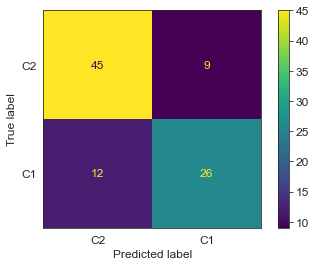

In [5]:
#Model Evaluation
y_pred = cpn.predict(X_test)
y_pred = np.where(y_pred>0.5,1,0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:",accuracy)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["C2", "C1"])
sns.set_style("white")
plt.rc('font', size=12)
disp.plot()
plt.show()

In [ ]:
params = {'hidden_size': np.arange(1, 100, 10),
           'num_epochs': np.arange(1, 100, 10),
           'learning_rate': np.linspace(0.01, 0.1, 10),
           'decay_rate': np.linspace(0.1, 0.9, 10)
          }
history = {'Accuracy': [],
            'Model':[]
           }
for i in range(10):
    cpn = CounterpropagationNetwork(input_size=2, output_size=1, hidden_size = params["hidden_size"][i])
    cpn.train(X_train, y_train,params["num_epochs"][i],params["learning_rate"][i],params["decay_rate"][i])
    y_pred = cpn.predict(X_test)
    y_pred = np.where(y_pred>0.5,1,0)
    accuracy = accuracy_score(y_test, y_pred)
    history["Accuracy"].append(accuracy)
    history["Model"].append(i)
print(history)